In [5]:
#https://github.com/gengshan-y/VCN
#https://github.com/google-research/opticalflow-autoflow/blob/main/src/dataset_lib/augmentations/aug_params.py

In [326]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from PIL import Image
from nnflow import flow_to_image, CustomDataloaderCreator

In [158]:
def plot_img_grid(imgs):
    imgs = torch.from_numpy(imgs.numpy().astype(np.uint8))
    #imgs = imgs.permute(0,3,1,2)
    
    plt.figure(figsize=(24,12))
    plt.axis('off')
    plt.imshow(make_grid(imgs, nrow=8).permute((1, 2, 0)))

In [220]:
if 'loader' in locals(): 
    del loader

loader = CustomDataloaderCreator(
    batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=False,
    crop_type="center",
    crop_size=[256,256],
    augment=False,
    norm_params= {"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]},
    aug_params={}
)

loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=True,
    crop_type="center",
    crop_size=[512,512],
    augment=True,
    norm_params= {"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]},
    aug_params={
        "spatial_aug_params": {
            "enabled": False,
            "aug_prob": 1, 
            "stretch_prob": 1, #0.8, 
            "min_scale": -0.1, 
            "max_scale": 1.0, 
            "max_stretch": 0.2, 
            "flip": False, 
            "h_flip_prob": 0.5, 
            "v_flip_prob": 0.1
        },
        "color_aug_params":{
            "enabled": False,
            "aug_prob": 0.2, 
            "brightness": 0.4, 
            "contrast": 0.4, 
            "saturation": 0.4, 
            "hue": 0.5 / 3.14
        },
        "eraser_aug_params": {
            "enabled": False,
            "aug_prob": 0.5,
            "bounds": [50, 100]
        },
        "noise_params": {
            "enabled": False,
            "aug_prob": 0.5,
            "noise_std_range": 0.06
        },
        "spatial_params": {
            "enabled": False,
            "scale": [0.0, 0.0, 0.1], # [0.3, 0.03, 0.1] [scale1, 0.03, scale2]
            "rot": [0.0, 0.0], #[0.4, 0.03] [rot1, 0.03]
            "trans": [0.0, 0.0], #[0.4, 0.03] [tran1, 0.03]
            "squeeze": [0.0, 0.0], #[0.3, 0.] [squeeze1, 0.]
            "black": False
        },
        "translate_params": {
            "enabled": False, 
            "aug_prob": 0.0,
            "translate": 10,
        },
        "rotate_params": {
            "enabled": False,
            "aug_prob": 0.0,
            "degrees": 10,
            "delta": 0,
        }
    }
)

loader.add_Kubric(
    root_dir="../../KubricFlow",
    split="validation",
    crop=True,
    crop_type="center",
    crop_size=[512,512],
    augment=True,
    norm_params= {"use":False, "mean":[127.5, 127.5, 127.5], "std":[127.5, 127.5, 127.5]},
    aug_params={
        "spatial_aug_params": {
            "enabled": True,
            "aug_prob": 1, 
            "stretch_prob": 1.0, #0.8, 
            "min_scale": 0.1,#-0.1, 
            "max_scale": 0.3,#1.0, 
            "max_stretch": 0.3,#0.2, 
            "flip": False, 
            "h_flip_prob": 0.5, 
            "v_flip_prob": 0.1
        },
        "color_aug_params":{
            "enabled": False,
            "aug_prob": 0.2, 
            "brightness": 0.4, 
            "contrast": 0.4, 
            "saturation": 0.4, 
            "hue": 0.5 / 3.14
        },
        "eraser_aug_params": {
            "enabled": False,
            "aug_prob": 0.5,
            "bounds": [50, 100]
        },
        "noise_params": {
            "enabled": False,
            "aug_prob": 0.5,
            "noise_std_range": 0.06
        },
        "spatial_params": {
            "enabled": False,
            "scale": [0.3, 0.03, 0.1], #[scale1, 0.03, scale2]
            "rot": [0.4, 0.03], #[rot1, 0.03]
            "trans": [0.4, 0.03], #[tran1, 0.03]
            "squeeze": [0.3, 0.], #[squeeze1, 0.]
            "black": False
        },
        "translate_params": {
            "enabled": False, 
            "aug_prob": 0.0,
            "translate": 10,
        },
        "rotate_params": {
            "enabled": False,
            "aug_prob": 0.0,
            "degrees": 10,
            "delta": 0,
        }
    }
)

In [221]:
ds_no_aug = loader.dataset_list[0]
ds_auto_flow_aug = loader.dataset_list[1]
ds_ezflow_aug = loader.dataset_list[2]
len(ds)

3381

In [222]:
(img_no_aug, img2), flow = ds_no_aug[2000]
(img_autoflow_aug, img2), flow = ds_auto_flow_aug[2000]
(img_ezflow_aug, img2), flow = ds_ezflow_aug[2000]

img_no_aug.shape, img_autoflow_aug.shape, img_ezflow_aug.shape

(torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 876, 876]))

In [223]:
img_no_aug = img_no_aug.unsqueeze(dim=0)
img_autoflow_aug = img_autoflow_aug.unsqueeze(dim=0)
img_ezflow_aug = img_ezflow_aug.unsqueeze(dim=0)

img_compare = torch.concat([img_no_aug, img_autoflow_aug, img_ezflow_aug], dim=0)
img_compare.shape

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 512 but got size 876 for tensor number 2 in the list.

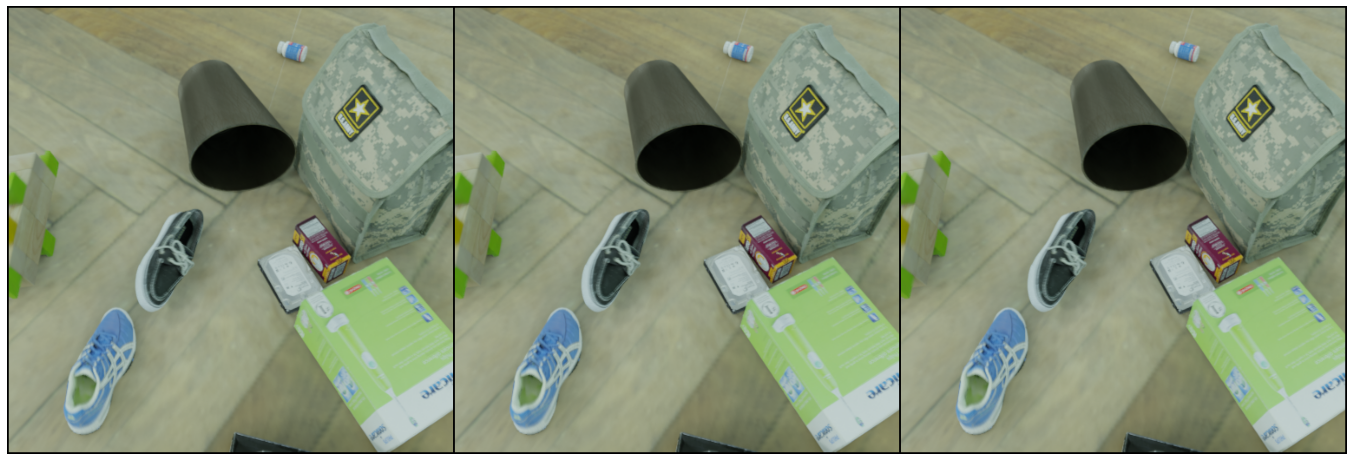

In [224]:
plot_img_grid(img_compare)

In [331]:
crop_size = (368,496)
H,W = 384,512
min_scale=np.maximum((crop_size[0] + 8) / float(H), (crop_size[1] + 8) / float(W))

min_scale

0.984375

In [333]:
for i in range(20):
    print(2 ** np.random.uniform(-0.1, 1.0))

1.023353425444772
1.655825034519738
1.1174225404818399
0.9334393668607529
1.2186918187666844
1.3820433211189636
1.0249390831450165
1.2194495321380014
1.5823324678393698
1.1462735790393312
1.889756874460832
1.6296665879192127
1.9271312786764807
1.3657072671203878
0.9782510581243341
1.5471563269417488
0.9536316311428376
1.0411993167064153
1.2336767119913798
1.6960683724328274


In [337]:
for i in range(20):
    print(2 ** np.random.uniform(min_scale, 1.0))

1.9880516225930938
1.9877858945711522
1.98738243977658
1.994708013730109
1.9867607883377512
1.9974673065667603
1.9830308181723033
1.9923169390024384
1.990598002323345
1.985175468512636
1.9818769303729675
1.9960578165179947
1.9929451912872593
1.9849896100149893
1.9899282190205976
1.9786397039144148
1.9851154725414797
1.9982957576614107
1.9791072482961816
1.9981340281971094


In [305]:
scale = 2 ** np.random.uniform(min_scale, 1.0)
scale

1.9925931987976204

In [282]:
scale = 2 ** np.random.uniform(min_scale, 1.0)
scale

1.987572761023342

In [283]:
scale_x = scale
scale_y = scale
scale_x, scale_y

(1.987572761023342, 1.987572761023342)

In [284]:
max_stretch=0.2

scale_x *= 2 ** np.random.uniform(-max_stretch,max_stretch)
scale_y *= 2 ** np.random.uniform(-max_stretch, max_stretch)

scale_x, scale_y

(2.115611478538841, 1.8844343833723078)

In [273]:
max_stretch=0.2

scale_x *= 2 ** np.random.uniform(-max_stretch,max_stretch)
scale_y *= 2 ** np.random.uniform(-max_stretch, max_stretch)

scale_x, scale_y

(1.5857049680070325, 1.5342616788253873)